In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, solve_ivp, fixed_quad, simpson, trapezoid
from scipy.special import kn
import astropy.constants as ct
import pandas as pd
from scipy.optimize import newton,curve_fit
from scipy.interpolate import interp1d
from scipy.differentiate import derivative
from ipywidgets import interact,fixed,widgets,interactive
import concurrent.futures as ft
from functools import partial

In [2]:
# Constants

vev = 246 # GeV - Higgs VEV
m_h = 125.2 # GeV - Higgs mass
Gamma_h = 4.07e-3 # GeV - total Higgs decay width
M_W = 80.3692 # GeV - W boson mass
M_Z = 91.188 # GeV - Z boson mass

m_e = 0.511e-3 # GeV - electron mass
m_muon = 105.66e-3 # GeV - muon mass
m_tau = 1.77693 # GeV - tau mass
m_u = 2.16e-3 # GeV - up mass
m_d = 4.7e-3 # GeV - down mass
m_c = 1.273 # GeV - charm mass
m_s = 93.5e-3 # GeV - strange mass
m_t = 172.57 # GeV - top mass
m_b = 4.183 # GeV - bottom mass

M_V = [M_W, M_Z]
M_f = [m_e,m_muon,m_tau,m_u,m_d,m_c,m_s,m_t,m_b]
n_cs = [1,1,1,3,3,3,3,3,3]

c_V = [1,1/2]

g_V = 3
g_f = 2

# C = 0.349 # no sé qué es esto
C = 1 - 5.792e-1 -6.240e-2 - 2.165e-4 - 2.876e-4

gstar = 106.75
MP = 2.4e18
T0 = 2.725*ct.k_B.value/ct.e.value*1e-9
gstars0 = 3.91
gstar0 = 3.38
s0 = 2*np.pi**2/45*gstars0*T0**3
rhoc0 = 4.78658e-5*1e6*ct.c.value**3*ct.hbar.value**3/ct.e.value**3*(1e-9)**4 # GeV⁴
gS = 1

s0mo = 2.8912e9*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)
rhoc0mo = 10.537*(ct.c.value/ct.hbar.value*ct.e.value*1e-9)**(-3)

In [3]:
s0, s0mo, rhoc0, rhoc0mo

(2.2208139221039978e-38,
 3.059942942537058e-35,
 3.677771412179473e-55,
 1.1151984914745777e-43)

In [4]:
# Relativistic degrees of freedom
rdof = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/Trabajo_de_grado/refs/heads/main/FIMP_fermion/rdof.csv')
rdof.loc[250,'Temp'] = T0
rdof['lnTemp'] = np.log(rdof['Temp'])
rdof['lnheff'] = np.log(rdof['g_s'])

In [5]:
# SM particles
SM_particles = pd.DataFrame(index=['h','W','Z','e','mu','tau','u','d','c','s','t','b'])
SM_particles['mass'] = np.array([m_h,]+M_V+M_f)
SM_particles['spin'] = np.array([0,1,1,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
SM_particles['n_c'] = np.array([1,1,1,1,1,1,3,3,3,3,3,3])
SM_particles['dof'] = 2*SM_particles['spin']+1
SM_particles['antiparticle'] = np.array([0.5,1,0.5,1,1,1,1,1,1,1,1,1])
SM_particles['name'] = np.array(['Higgs','W± boson','Z0 boson','electron','muon','tau','up quark','down quark','charm quark','strange quark','top quark','bottom quark'])

In [6]:
# RDOF equations
heff = interp1d(rdof['Temp'][::-1],rdof['g_s'][::-1],bounds_error=False,fill_value=(rdof['g_s'].values[-1],rdof['g_s'].values[0]))
geff = interp1d(rdof['Temp'][::-1],rdof['g_rho'][::-1],bounds_error=False,fill_value=(rdof['g_rho'].values[-1],rdof['g_rho'].values[0]))
lnheff = interp1d(rdof['lnTemp'][::-1],rdof['lnheff'][::-1],bounds_error=False,fill_value=(rdof['lnheff'].values[-1],rdof['lnheff'].values[0]))
der = derivative(lnheff,rdof['lnTemp']).df
dlnheffdlnT = interp1d(rdof['lnTemp'][::-1],der[::-1],bounds_error=False,fill_value=(der[-1],der[0]))

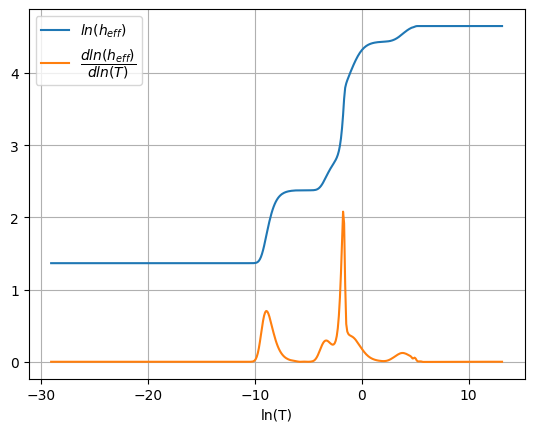

In [7]:
# Graph of RDOF
der = derivative(lnheff,rdof['lnTemp']).df

plt.plot(rdof['lnTemp'],rdof['lnheff'],label=r'$ln(h_{eff})$')
plt.plot(rdof['lnTemp'],dlnheffdlnT(rdof['lnTemp']),label=r'$\dfrac{dln(h_{eff})}{dln(T)}$')
plt.xlabel('ln(T)')
plt.grid()
plt.legend()
plt.show()

### Cross sections

(1) $$\sigma_{VV\rightarrow SS}=g_{V}^{-2}\frac{\lambda_{HS}^{2}}{32\pi s}\sqrt{\frac{s-4M_{S}^{2}}{s-4M_{V}^{2}}}\frac{s^{2}-4sM_{V}^{2}+12M_{V}^{4}}{(s-m_{h}^{2})^{2}+m_{h}^{2}\Gamma_{h}^{2}}$$

(2) $$\sigma_{f\bar{f}\rightarrow SS}=g_{f}^{-2}\frac{\lambda_{HS}^{2}n_{c}}{16\pi s}\frac{\sqrt{(s-4M_{f}^{2})(s-4M_{S}^{2})}M_{f}^{2}}{(s-m_{h}^{2})^{2}+m_{h}^{2}\Gamma_{h}^{2}}$$

(3) $$\sigma_{hh\rightarrow SS}=\frac{1}{32\pi s}\sqrt{\frac{s-4M_{S}^{2}}{s-4M_{h}^{2}}}\left|\lambda_{HS}+\frac{3m_{h}^{2}\lambda_{HS}}{s-m_{h}^{2}+im_{h}\Gamma_h}-\frac{4v^{2}\lambda_{HS}^{2}}{s-2m_{h}^{2}}\right|^{2}$$

### Higgs' decay rate

(4) $$\Gamma_{h\to SS}=\frac{\lambda_{HS}^{2}v^{2}}{32\pi m_{h}}\sqrt{1-\frac{4M_{S}^{2}}{m_{h}^{2}}}$$



In [8]:
def sigma_s(s,M_S,lambda_HS,initial_particle):
    lambda_HS = 2*lambda_HS
    
    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if (s-4*M_S**2)/(s-4*M**2)>0:  # Eq. 3
            A_ = g**-2*lambda_HS**2/(32*np.pi*s)
            B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
            C_ = (lambda_HS+3*M/(s-M**2+1j*M*Gamma_h)-4*vev**2*lambda_HS/(s-2*M**2))
            return A_*B_*np.abs(C_)**2
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        if (s-4*M_S**2)/(s-4*M**2)>0: # Eq. 1
            A_ = g**-2*lambda_HS**2/(32*np.pi*s)
            B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
            C_ = (s**2-4*s*M**2+12*M**4)/((s-m_h**2)**2+m_h**2*Gamma_h**2)
            return A_*B_*C_
        else:
            return 0
    if SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        if (s-4*M_S**2)*(s-4*M**2)>0:   # Eq. 2
            A_ = g**-2*lambda_HS**2*n/(16*np.pi*s)
            B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
            C_ = 1/((s-m_h**2)**2+m_h**2*Gamma_h**2)
            return A_*B_*C_
        else:
            return 0

def Gamma_hSS(lambda_HS,M_S):
    lambda_HS = 2*lambda_HS
    if M_S < m_h/2:   # Eq. 4
        return lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2)**0.5
    else:
        return 0
    
sigma_s = np.vectorize(sigma_s)
Gamma_hSS = np.vectorize(Gamma_hSS)

In [9]:
def sigma_s(s,M_S,lambda_HS,initial_particle):
    lambda_HS = 2*lambda_HS
    
    s = np.asarray(s)

    if initial_particle == 'h':
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        valid = (s - 4*M_S**2) > 0
        valid &= (s - 4*M**2) > 0  # Eq. 3
        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
        C_ = (lambda_HS+3*M/(s-M**2+1j*M*Gamma_h)-4*vev**2*lambda_HS/(s-2*M**2))
        sigma = A_ * B_ * np.abs(C_)**2
        return np.where(valid, sigma, 0)

    elif SM_particles.loc[initial_particle]['spin'] == 1.:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        valid = (s - 4*M_S**2) > 0
        valid &= (s - 4*M**2) > 0
        A_ = g**-2*lambda_HS**2/(32*np.pi*s)
        B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
        C_ = (s**2-4*s*M**2+12*M**4)/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        sigma = A_ * B_ * C_
        return np.where(valid, sigma, 0)
    
    elif SM_particles.loc[initial_particle]['spin'] == 0.5:
        M = SM_particles.loc[initial_particle]['mass']
        g = SM_particles.loc[initial_particle]['dof']
        n = SM_particles.loc[initial_particle]['n_c']
        valid = (s - 4*M_S**2) > 0
        valid &= (s - 4*M**2) > 0
        A_ = g**-2*lambda_HS**2*n/(16*np.pi*s)
        B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
        C_ = 1/((s-m_h**2)**2+m_h**2*Gamma_h**2)
        sigma = A_ * B_ * C_
        return np.where(valid, sigma, 0)

def Gamma_hSS(lambda_HS,M_S):
    lambda_HS = 2*lambda_HS
    if M_S < m_h/2:   # Eq. 4
        return lambda_HS**2*vev**2/(32*np.pi*m_h)*(1-4*M_S**2/m_h**2)**0.5
    else:
        return 0
    
Gamma_hSS = np.vectorize(Gamma_hSS)

```
import time

start = time.perf_counter()


def do_something(seconds):
    print(f'Sleeping {seconds} second(s)...')
    time.sleep(seconds)
    return f'Done Sleeping...{seconds}'


with ft.ProcessPoolExecutor() as executor:
    secs = [5, 4, 3, 2, 1]
    results = executor.map(do_something, secs)

    # for result in results:
    #     print(result)

finish = time.perf_counter()

print(f'Finished in {round(finish-start, 2)} second(s)')
```

In [10]:
def calc_integrand_(part,ss,M_S,l_HS,T):
    M = SM_particles.loc[part]['mass']
    return sigma_s(ss,M_S,l_HS,part)*(ss-4*M**2)*ss**0.5*kn(1,ss**0.5/T)

def graf1(M_S,l_HS,T):
    ss = np.logspace(0,30,10000)
    
    with ft.ProcessPoolExecutor() as executor:
        part_names = SM_particles.index
        f = partial(calc_integrand_, ss=ss, M_S=M_S, l_HS=l_HS, T=T)
        sigmas = executor.map(f, part_names)

    fig,ax = plt.subplots(1,4,figsize=(18,4))
    for i,res in enumerate(sigmas):
        ax[i//3].loglog(ss,res,label=part_names[i])
        ax[i//3].axvline(4*SM_particles.iloc[i]['mass']**2)
        ax[i//3].grid()
        ax[i//3].legend()
    plt.show()
    
slider_M_S = widgets.FloatLogSlider(value=100, base=10, min=0, max=4,
                                  step=0.01, description='mass')
slider_l_HS = widgets.FloatLogSlider(value=1e-11, base=10, min=-13, max=-9,
                                  step=0.1, description='sigma')
slider_T = widgets.FloatLogSlider(value=1, base=10, min=-12, max=12,
                                  step=0.1, description='T')

interactive_plot1 = interactive(graf1, M_S=slider_M_S, l_HS=slider_l_HS, T=slider_T,
                                continuous_update=0)

# Muestra la función interactiva
interactive_plot1

interactive(children=(FloatLogSlider(value=100.0, description='mass', step=0.01), FloatLogSlider(value=1e-11, …

### Thermal average

(5) $$\langle\sigma v\rangle=\frac{1}{8Tm_{X}^{4}K_{2}^{2}(\frac{m_{X}}{T})}\int_{4m_{X}^{2}}^{\infty}\sigma(s-4m_{X}^{2})\sqrt{s}K_{1}\left(\frac{\sqrt{s}}{T}\right)\mathrm{d}s$$

### Number density at equilibrium

(6) $$\overline{n}_{X}=\frac{g_{X}}{2\pi^{2}}Tm_{X}^{2}K_{2}\left(\frac{m_{X}}{T}\right)$$

### Boltzmann equation

(7) $$\dot{n}_{S}+3Hn_{S}=\sum_{x}\langle\sigma_{X\bar{X}\to SS}v\rangle\overline{n}_{X}^{2}+\dfrac{Cm_{h}\Gamma_{h\to SS}T}{2\pi^2}K_1\left(\frac{m_h}{T}\right)$$

(8) $$\frac{\mathrm{d}Y}{\mathrm{d}T}=-\frac{1}{s\bar{H}T}\left(\sum_{X}\left\langle\sigma_{X\bar{X}\to SS}v\right\rangle\bar{n}_{X}^{2}+\frac{Cm_{h}\Gamma_{h\to ss}T}{2\pi^{2}}K_{1}\left(\frac{m_{h}}{T}\right)\right)$$

### Entropy density

(9) $$s=\frac{2\pi^2}{45}T^3h_{\mathrm{eff}}(T)$$

### Hubble expansion rate

(10) $$H=\frac{1}{M_{P}}\sqrt{\frac{\pi^{2}}{90}g_\mathrm{eff}(T)}T^{2}$$

(11) $$\overline{H}=\frac{H}{1+\frac{1}{3}\frac{\mathrm{d}\ln h_\mathrm{eff}}{\mathrm{d}\ln T}}$$

### Scale factor

(12) $$a(T)=e^{\int_{\ln T}^{\ln T_{0}}1+\frac{1}{3}\frac{d\ln h_\mathrm{eff}}{\mathrm{d}\tau}\mathrm{d}\tau}$$

In [11]:
def calc_integrand(ss,part,M_S,l_HS,T):
    M = SM_particles.loc[part]['mass']
    return sigma_s(ss,M_S,l_HS,part)*(ss-4*M**2)*ss**0.5*kn(1,ss**0.5/T)

In [12]:
def sigmavxneq(part,M_S,lambda_HS,T):
    M = SM_particles.loc[part]['mass']
    g = SM_particles.loc[part]['dof']
    ss = np.logspace(np.log10(4*M**2+1e-10),30,10000)
    fs = calc_integrand(ss,part,M_S,lambda_HS,T)
    bB2 = (fs[:-1]+fs[1:])/2
    deltas = ss[1:]-ss[:-1]
    return (g**2/(32*np.pi**4))*bB2@deltas

def term1(M_S,lambda_HS,T):
    with ft.ProcessPoolExecutor() as executor:
        part_names = SM_particles.index
        f = partial(sigmavxneq, M_S=M_S, lambda_HS=lambda_HS, T=T)
        sigmas = np.array(list(executor.map(f, part_names)))
    return np.sum(sigmas)

def term2(M_S,lambda_HS,T):
    return C*m_h*Gamma_hSS(lambda_HS,M_S)*T/(2*np.pi**2)*kn(1,m_h/T)

def Hubblerate(T):
        HMS = (np.pi**2*geff(T)/90)**0.5*T**2/MP
        return HMS/(1+(1/3)*dlnheffdlnT(np.log(T)))

def entropydensity(T):
     return 2*np.pi**2/45*heff(T)*T**3

In [13]:
sigmavxneq('h',100.,1e-11,1e6)

2.0230383004639796e-21

In [147]:
part = 't'
M_S = 10000
lambda_HS = 1e-11
T = 1e6

M = SM_particles.loc[part]['mass']
g = SM_particles.loc[part]['dof']
ss_ = np.logspace(np.log10(4*M**2+1e-10),30,10000)
fs = calc_integrand(ss_,part,M_S,lambda_HS,T)
# ss = ss_[ss_>4*M**2]
# fs = fs[ss_>4*M**2]

/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5


In [144]:
fs[fs!=0]

array([1.83238158e-031, 3.18308169e-031, 4.06876622e-031, ...,
       2.96439388e-322, 4.44659081e-323, 4.94065646e-324])

In [129]:
fs = np.zeros_like(ss_)
for i in range(len(fs)):
    fs[i] = calc_integrand(ss_[i],part,M_S,lambda_HS,T)

In [161]:
def Omegah2(M_S,lambda_HS,TR):
    f = lambda T: -1/(T*entropydensity(T)*Hubblerate(T)) * (term1(M_S, lambda_HS, T) + term2(M_S, lambda_HS, T))
    Y = quad(f,TR,T0)[0]
    Omega = s0mo*M_S*Y/rhoc0mo
    return Omega

In [162]:
Omegah2(1e4,1e-11,1e6)

/tmp/ipykernel_12231/3669202888.py:23: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:23: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:12: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(

3.07703517646949e-06

In [160]:
Ts = np.logspace(6,np.log10(T0),1000)
Boltz_eq(M_S,lambda_HS,Ts)

/tmp/ipykernel_12231/3669202888.py:12: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:23: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)/(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(s-4*M**2))**0.5
/tmp/ipykernel_12231/3669202888.py:35: RuntimeWarning: invalid value encountered in sqrt
  B_ = ((s-4*M_S**2)*(

array([1.57834211e-028, 1.79525672e-028, 2.04197547e-028, 2.32259188e-028,
       2.64176139e-028, 3.00477836e-028, 3.41766369e-028, 3.88726436e-028,
       4.42136669e-028, 5.02882497e-028, 5.71970778e-028, 6.50546419e-028,
       7.39911276e-028, 8.41545628e-028, 9.57132581e-028, 1.08858580e-027,
       1.23808102e-027, 1.40814072e-027, 1.60154965e-027, 1.82148040e-027,
       2.07156697e-027, 2.35595670e-027, 2.67934963e-027, 3.04708211e-027,
       3.46520462e-027, 3.94062526e-027, 4.48119377e-027, 5.09581137e-027,
       5.79461796e-027, 6.58913819e-027, 7.49238882e-027, 8.51916740e-027,
       9.68635295e-027, 1.10130946e-026, 1.25211108e-026, 1.42350284e-026,
       1.61828337e-026, 1.83963479e-026, 2.09116714e-026, 2.37697004e-026,
       2.70172236e-026, 3.07066711e-026, 3.48974828e-026, 3.96573832e-026,
       4.50632922e-026, 5.12022348e-026, 5.81726841e-026, 6.60867068e-026,
       7.50702530e-026, 8.52655984e-026, 9.68347735e-026, 1.09961788e-025,
       1.24854067e-025, 1

2.9851976643109317e-25

In [96]:
simpson(fs,ss)

9.306021494158142e-22

In [92]:
quad(lambda s: calc_integrand('h',s,M_S,lambda_HS,T),4*M**2,1e30)

(0.0, 0.0)